- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys

p = os.path.abspath('../../..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


# SVD 문장 데이터에서 Feature 추출
- mfcc

In [18]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

In [19]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

pathology_sig=[]
healthy_sig=[]

pathology=[]
healthy=[]


#PATHOLOGY DATA
for audio_path in os.listdir('D:/project/voice_pathology_ai/voice_data/organics/pathology/phrase/'):
    sig, sr = librosa.load('D:/project/voice_pathology_ai/voice_data/organics/pathology/phrase/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    pathology_sig.append(sig)
    stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    pathology.append(log_spectrogram)
    

#Healthy data
for audio_path in os.listdir('D:/project/voice_pathology_ai/voice_data/organics/healthy/phrase/'):
    sig, sr = librosa.load('D:/project/voice_pathology_ai/voice_data/organics/pathology/phrase/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    healthy_sig.append(sig)
    stft = librosa.stft(sig,win_length=win_length ,n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    healthy.append(log_spectrogram)
    
print("pathology data 수 : ",len(pathology))
print("healthy data 수 : ",len(healthy))


path_max=max([ len(samples) for samples in pathology_sig])
healthy_max=max([ len(samples) for samples in healthy_sig])
print("가장 긴 path sample :" ,path_max)
print("가장 긴 healthy sample :" ,healthy_max)

C:\Users\USER\AppData\Local\Temp/ipykernel_22696/3851933931.py:33: UserWarning: PySoundFile failed. Trying audioread instead.
  sig, sr = librosa.load('D:/project/voice_pathology_ai/voice_data/organics/pathology/phrase/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ


FileNotFoundError: [Errno 2] No such file or directory: 'D:/project/voice_pathology_ai/voice_data/organics/pathology/phrase/1-phrase.wav'

In [ ]:
print(path_max/sr,"초")
print(healthy_max/sr,"초")

# 결과 확인
- 1 row당 1 frame으로

In [5]:
len(healthy[0][2]) #1번 : 파일. 2번:mfcc
#headers = "mfcc1 mfcc2 mfcc3 mfcc4 mfcc5 mfcc6 mfcc7 mfcc8 mfcc9 mfcc10 mfcc11 mfcc12 mfcc13".split()
#pd.DataFrame(healthy[0].T,columns=headers)

print(healthy[0])




[[ -8.41268    -7.705823   -9.314145  ...  -3.2875543  -9.481657
  -14.334839 ]
 [ -9.690009   -7.0746346  -5.761348  ...  -5.3182898  -6.9227552
   -9.569631 ]
 [-13.675301  -12.412195  -29.27149   ... -16.410295  -20.021296
  -10.153454 ]
 ...
 [-43.8044    -43.8044    -43.8044    ... -43.8044    -43.8044
  -43.8044   ]
 [-43.8044    -43.8044    -43.8044    ... -43.8044    -43.8044
  -43.8044   ]
 [-43.8044    -43.8044    -43.8044    ... -43.8044    -43.8044
  -43.8044   ]]


In [6]:
print(healthy[0].shape) #1번 주파수 축, 2번 시간축.
print(healthy[1].shape)

(626, 326)
(626, 338)


In [7]:
del pathology
del healthy
del pathology_sig
del healthy_sig

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

## 1. test/ train 나누기


In [2]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


pathology = glob('D:/project/voice_pathology_ai/voice_data/organics/pathology/phrase/*.wav')
healthy = glob('D:/project/voice_pathology_ai/voice_data/organics/healthy/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

pathology= [ path.split("\\")[-1] for path in pathology] # path 데이터 변환.
healthy= [ path.split("\\")[-1] for path in healthy] # path 데이터 변환.


X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<597:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  597
Healthy:  634
총 데이터수 :  1231
---
훈련 셋 :  984 Counter({'healthy': 507, 'pathology': 477})
테스트 셋 :  247 Counter({'healthy': 127, 'pathology': 120})
---


## 2. stratified k-fold

In [3]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 381}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 96} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 381}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 96} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 95} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 95} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 382}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 95} 



## 3. random over sampling

In [4]:
#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res




 fold0 
before dataset shape Counter({'healthy': 406, 'pathology': 381})
Resampled dataset shape Counter({'pathology': 406, 'healthy': 406})

 fold1 
before dataset shape Counter({'healthy': 406, 'pathology': 381})
Resampled dataset shape Counter({'healthy': 406, 'pathology': 406})

 fold2 
before dataset shape Counter({'healthy': 405, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})

 fold3 
before dataset shape Counter({'healthy': 405, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 405, 'healthy': 405})

 fold4 
before dataset shape Counter({'healthy': 406, 'pathology': 382})
Resampled dataset shape Counter({'pathology': 406, 'healthy': 406})


##  데이터 미리 읽기

In [5]:
import pickle

 
#load
with open("D:/project/voice_pathology_ai/voice_data/organics_fusion/phrase_msf_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)


#load
with open("D:/project/voice_pathology_ai/voice_data/organics_fusion/a_msf_dict.pickle","rb") as fr:
    a_dict = pickle.load(fr)
    
    
    

# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [6]:
from torch.utils.data import Dataset, DataLoader

classes = ["pathology","healthy"]
sr=16000
win_length =  np.int64(16000/40) # 400
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 300프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        number=self.path_list[idx].split('-')[0]
        path_a=number+"-a_n.wav"
        
        log_spectrogram_phrase = phrase_dict[self.path_list[idx]][0]
        mel_feature_phrase = phrase_dict[self.path_list[idx]][1]
        MFCCs_phrase = phrase_dict[self.path_list[idx]][2]
        
        log_spectrogram_a= a_dict[path_a][0]
        mel_feature_a = a_dict[path_a][1]
        MFCCs_a = a_dict[path_a][2]         

        
        #300frame padding
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        length=300
        log_spectrogram_phrase = pad2d(log_spectrogram_phrase, length)
        mel_feature_phrase = pad2d(mel_feature_phrase, length)
        MFCCs_phrase = pad2d(MFCCs_phrase, length)
        
        log_spectrogram_a = pad2d(log_spectrogram_a, length)
        mel_feature_a = pad2d(log_spectrogram_a, length)
        MFCCs_a = pad2d(log_spectrogram_a, length) 
        
        if self.transform:
            #print('transform')
            log_spectrogram_phrase=self.transform(log_spectrogram_phrase).type(torch.float32)# 데이터 타입 변화
            log_spectrogram_a=self.transform(log_spectrogram_a).type(torch.float32)# 데이터 타입 변화
            
            MFCCs_phrase=self.transform(MFCCs_phrase).type(torch.float32)# 데이터 타입 변화
            MFCCs_a=self.transform(MFCCs_a).type(torch.float32)# 데이터 타입 변화
            
            mel_feature_phrase=self.transform(mel_feature_phrase).type(torch.float32)# 데이터 타입 변화
            mel_feature_a=self.transform(mel_feature_a).type(torch.float32)# 데이터 타입 변화
            
            MSF_phrase=torch.stack([log_spectrogram_phrase,mel_feature_phrase,MFCCs_phrase])# 3채널로 복사.
            MSF_a=torch.stack([log_spectrogram_a,mel_feature_a,MFCCs_a])# 3채널로 복사.

            
            MSF_phrase = MSF_phrase.squeeze(dim=1)
            MSF_a = MSF_a.squeeze(dim=1)

        else:
            ## 사용안하는 곳##########
            #print("else")
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF_phrase,MSF_a,self.classes.index(self.label[idx])
    
    

In [7]:
# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes
        self.transform=transform
        
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 300프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        number=self.path_list[idx].split('-')[0]
        path_a=number+"-a_n.wav"
        
        log_spectrogram_phrase = phrase_dict[self.path_list[idx]][0]
        mel_feature_phrase = phrase_dict[self.path_list[idx]][1]
        MFCCs_phrase = phrase_dict[self.path_list[idx]][2]
        
        log_spectrogram_a= a_dict[path_a][0]
        mel_feature_a = a_dict[path_a][1]
        MFCCs_a = a_dict[path_a][2]         
        
        
        #300frame padding
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        length=300
        log_spectrogram_phrase = pad2d(log_spectrogram_phrase, length)
        mel_feature_phrase = pad2d(mel_feature_phrase, length)
        MFCCs_phrase = pad2d(MFCCs_phrase, length)
        
        log_spectrogram_a = pad2d(log_spectrogram_a, length)
        mel_feature_a = pad2d(log_spectrogram_a, length)
        MFCCs_a = pad2d(log_spectrogram_a, length) 
        
        
        if self.transform:
            #print('transform')
            log_spectrogram_phrase=self.transform(log_spectrogram_phrase).type(torch.float32)# 데이터 타입 변화
            log_spectrogram_a=self.transform(log_spectrogram_a).type(torch.float32)# 데이터 타입 변화
            
            MFCCs_phrase=self.transform(MFCCs_phrase).type(torch.float32)# 데이터 타입 변화
            MFCCs_a=self.transform(MFCCs_a).type(torch.float32)# 데이터 타입 변화
            
            mel_feature_phrase=self.transform(mel_feature_phrase).type(torch.float32)# 데이터 타입 변화
            mel_feature_a=self.transform(mel_feature_a).type(torch.float32)# 데이터 타입 변화
            
            MSF_phrase=torch.stack([log_spectrogram_phrase,mel_feature_phrase,MFCCs_phrase])# 3채널로 복사.
            MSF_a=torch.stack([log_spectrogram_a,mel_feature_a,MFCCs_a])# 3채널로 복사.

            
            MSF_phrase = MSF_phrase.squeeze(dim=1)
            MSF_a = MSF_a.squeeze(dim=1)

        else:
            ## 사용안하는 곳##########
            #print("else")
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF_phrase,MSF_a,self.classes.index(self.label[idx])
    

# 데이터 로더

In [8]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 음성데이터
EPOCHS = 50 # 전체 데이터 셋을 50번 반복

In [9]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인


"""
transform = transforms.Compose([
                                                            transforms.ToTensor(),
                                                            transforms.Normalize([-4.907,-30.4985,-1.0402],
                                                                                 [14.0364,25.289,26.997])
                                                        ]),#이걸 composed로 고쳐서 전처리 하도록 수정.

"""

train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform = transforms.ToTensor(),
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



In [10]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 

# 데이터 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_train :  torch.Size([32, 3, 128, 300]) 
a :  torch.Size([32, 3, 128, 300])
Y_train :  torch.Size([32]) type: torch.LongTensor
tensor(1)


Text(0.5, 1.0, 'Spectrogram (dB)')

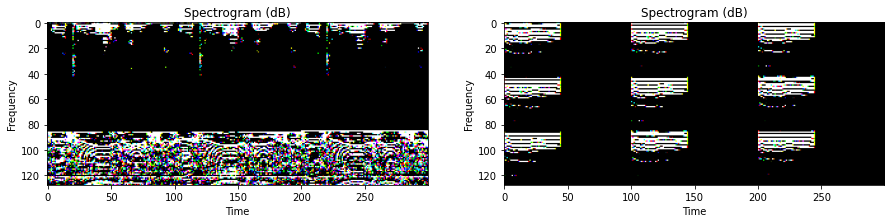

In [11]:
# 4. 데이터 확인하기
for (X_train,a,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'\na : ',a.size())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(X_train[0].view(128,300,3).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

plt.subplot(122)
plt.imshow(a[0].view(128,300,3).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")



#plt.xlabel("Time")
#plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')
#plt.title("Spectrogram (dB)")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_valid :  torch.Size([32, 3, 128, 300]) 
a :  torch.Size([32, 3, 128, 300])
Y_train :  torch.Size([32]) type: torch.LongTensor
tensor(1)


Text(0.5, 1.0, 'Spectrogram (dB)')

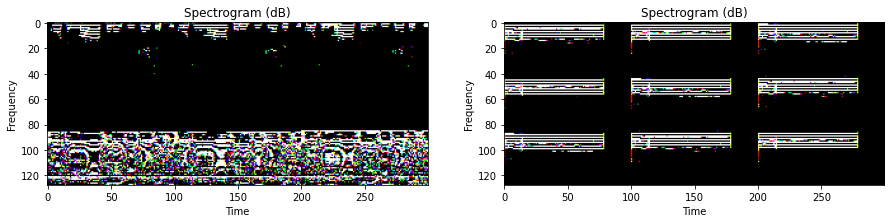

In [12]:
#valiation set 확인
for (X_valid,a,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'\na : ',a.size())
    print("Y_train : ",Y_valid.size(),'type:',Y_valid.type())
    break
    
print(Y_valid[0])
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(X_valid[0].view(128,300,3).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

plt.subplot(122)
plt.imshow(a[0].view(128,300,3).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")



X_valid :  torch.Size([32, 3, 128, 300]) 
a :  torch.Size([32, 3, 128, 300])
Y_train :  torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


Text(0.5, 1.0, 'Spectrogram (dB)')

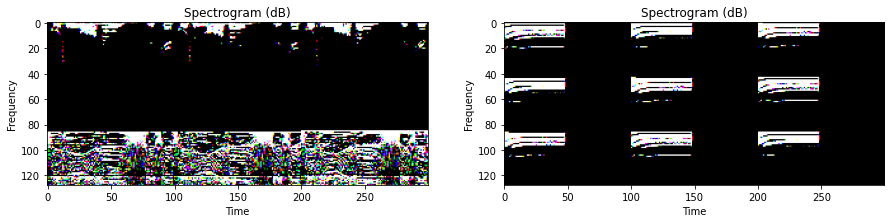

In [13]:
#Test set 확인
for (X_test,a_test,Y_test) in test_loader:
    print("X_valid : ",X_test.size(),'\na : ',a_test.size())
    print("Y_train : ",Y_test.size(),'type:',Y_test.type())
    break
    
print(Y_test[0])
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(X_test[0].view(128,300,3).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

plt.subplot(122)
plt.imshow(a_test[0].view(128,300,3).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")


# RESNET

- https://titania7777.tistory.com/8 : adaptive pooling 2d . 배치 사이즈에따라 feature map은 크기가 다르기에 이용.

In [14]:

input_size1 = 1 # node가 512 time step ,1 차원데이터
hidden_size1 = 2 # 마지막 출력은 2 class ->bidirectional은 2배
num_layers=1 # 1 레이어 lstm

class Lstm_feature(nn.Module):
    def __init__(self,n_class=hidden_size1):
        super(Lstm_feature,self).__init__() # 상속받기
        self.lstm1 = nn.LSTM(input_size=input_size1,
                             hidden_size=n_class,
                             num_layers=num_layers,
                             batch_first = True,
                             bidirectional=False,
                             bias=True)
    
        self.res_model = models.resnet18(pretrained=True)
        self.res_model.ftrs = self.res_model.fc.in_features # in_features : fully connected의 입력수.
        num_ftrs = self.res_model.fc.in_features
        self.res_model=torch.nn.Sequential(*(list(self.res_model.children())[:-1]))
        
    
    def forward(self,x):
        data=self.res_model(x)
        data=data.squeeze(2)
        data,_=self.lstm1(data) # (output, 최종 hidden)
        x=data[:,-1,:].squeeze()
        return x    


    

class resnet18_map(nn.Module):
    def __init__(self,pretrained=True):
        super().__init__()
        self.model = models.resnet18(pretrained=pretrained)
        self.num_ftrs = 1000 # feature map이 가공되면 최종 사이즈가 될 것임.
        
    def forward(self,images):
        embedding = self.model(images) # embedding 생성
        return embedding
        
        
        
    
class resnet18_fusion(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """

    def __init__(self, n_class=2):
        super(resnet18_fusion, self).__init__()


        model1 = Lstm_feature()
        model1_map = resnet18_map()
        
        self.phrase_model = model1
        self.mapPhrase = model1_map


        map_in_features = self.mapPhrase.num_ftrs
        

        model2 = Lstm_feature()
        model2_map = resnet18_map()
        
        self.a_model = model2
        self.mapA = model2_map

        
        self.combine_map_forward = nn.Sequential(
            nn.Linear(map_in_features * 2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(50,n_class)
            #nn.Sigmoid()
        )
        
        self.prediction_forward = nn.Sequential(
            nn.Linear(n_class * 3, n_class),
            #nn.Sigmoid()
        )
        
        
        
        

    def forward(self, phrase,a):
        phrase_feature = self.phrase_model(phrase)# cross entropy loss는 logit을 넘겨야 하기 때문.
        #lstm 결과
        phrase_feature_res = torch.sigmoid(phrase_feature)
        
        phrase_map = self.mapPhrase(phrase)
        
        a_feature = self.a_model(a) #lstm 결과
        #a_feature_res = torch.sigmoid(a_feature)
        
        
        a_map = self.mapA(a)
        combine = torch.cat((phrase_map,
                             a_map,), 1)
        
        combine = self.combine_map_forward(combine)
        #combine_res = torch.sigmoid(combine)
        
        
        combine2 = torch.cat((phrase_feature,a_feature,combine),1)
        
        combine_last = self.prediction_forward(combine2)
        
        return phrase_feature, a_feature, combine, combine_last

In [20]:
class resnet18_feature(nn.Module):
    def __init__(self, embedding_dimension=512, pretrained=True,n_class=2):
        super().__init__()
        self.model = models.resnet18(pretrained=pretrained)
        
        # embedding
        self.input_features_fc_layer = self.model.fc.in_features # fc layer 채널 수 얻기
        #print(input_features_fc_layer)
        #self.model.fc = nn.Linear(input_features_fc_layer, embedding_dimension, bias=True) # fc layer 수정
        self.model.fc =  nn.Sequential(
            nn.Linear(self.input_features_fc_layer,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256,50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(50,n_class)
            #nn.Sigmoid()
        )
        
    def forward(self, images):
        embedding = self.model(images) # embedding 생성
        return embedding

class resnet18_map(nn.Module):
    def __init__(self,pretrained=True):
        super().__init__()
        self.model = models.resnet18(pretrained=pretrained)
        self.model = torch.nn.Sequential(*(list(self.model.children())[:-2]))# 마지막 두 레이어는 없앤다. 피처맵 추출위해서.
        self.num_ftrs = 512 # feature map이 가공되면 최종 사이즈가 될 것임.
        
    def forward(self,images):
        embedding = self.model(images) # embedding 생성
        return embedding
        
        
        
    
class resnet18_fusion(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """

    def __init__(self, n_class=2):
        super(resnet18_fusion, self).__init__()


        model1 = resnet18_feature()
        model1_map = resnet18_map()
        self.phrase_model = model1
        self.mapPhrase = model1_map

        
        #in_features = self.phrase_model.input_features_fc_layer
        map_in_features = self.mapPhrase.num_ftrs
        

        model2 = resnet18_feature()
        model2_map = resnet18_map()
        self.a_model = model2
        self.mapA = model2_map

        
        self.combine_map_forward = nn.Sequential(
            nn.Linear(map_in_features * 2, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256,50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(50,n_class)
            #nn.Sigmoid()
        )
        
        self.prediction_forward = nn.Sequential(
            nn.Linear(n_class * 3, n_class),
            #nn.Sigmoid()
        )
        

    def forward(self, phrase,a):
        phrase_feature = self.phrase_model(phrase)# cross entropy loss는 logit을 넘겨야 하기 때문.
        phrase_feature_res = F.sigmoid(phrase_feature)
        
        phrase_map = self.mapPhrase(phrase)
        
        phrase_map = F.relu(phrase_map,inplace=False)
        phrase_map = F.adaptive_avg_pool2d(phrase_map, (1, 1)).view(phrase_map.size(0), -1)
        
        a_feature = self.a_model(a)
        a_feature_res = F.sigmoid(a_feature)
        
        
        a_map = self.mapA(a)
        a_map = F.relu(a_map,inplace=False)
        a_map = F.adaptive_avg_pool2d(a_map, (1, 1)).view(a_map.size(0), -1)#배치별로 다 512 노드를 가진 데이터로 뭉침.

        combine = torch.cat((phrase_map,
                             a_map,), 1)
        combine = self.combine_map_forward(combine)
        combine_res = F.sigmoid(combine)
        
        
        combine2 = torch.cat((phrase_feature_res,a_feature_res,combine_res),1)
        
        combine_last = self.prediction_forward(combine2)
        
        return phrase_feature, a_feature, combine, combine_last

In [21]:
# 모델 
# pretrained


def model_initialize():
    model = resnet18_fusion(n_class=2).to(DEVICE)

    return model

model= model_initialize()
print(model)

resnet18_fusion(
  (phrase_model): resnet18_feature(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

In [22]:
#8. 학습

w = [0.1,0.1,0.1,0.7]
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(phrase,a,label) in enumerate(train_loader):
        phrase = phrase.to(DEVICE)
        a = a.to(DEVICE)
        label = label.to(DEVICE)
        
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output_phrase,output_a,output_combine1,output_combine2 = model(phrase,a) # model로 output을 계산
        
        loss1 = criterion(output_phrase, label) #loss 계산
        loss2 = criterion(output_a, label) #loss 계산
        loss3 = criterion(output_combine1, label) #loss 계산
        loss4 = criterion(output_combine2, label) #loss 계산

        
        loss_total=w[0]*loss1+w[1]*loss2+w[2]*loss3+w[3]*loss4
        
        #여기부터 수정해야함. 2022.02.18
        
        
        #####
        train_loss += loss_total.item()
        prediction = output_combine2.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss_total.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [23]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for phrase,a,label in valid_loader:
            phrase = phrase.to(DEVICE)
            a = a.to(DEVICE)
            label = label.to(DEVICE)
            
            _,_,_,output = model(phrase,a)
            
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [24]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    return train_loader,validation_loader



In [19]:
#10. 학습 및 평가.
# resnet18 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = '../../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_MSFnet_lstm.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 10, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)
            
            


../../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_MSFnet_lstm.pt
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0173	 Train Acc:78.33 %  | 	Valid Loss:0.0152 	Valid Acc: 79.70 %

Validation loss decreased (inf --> 0.015215).  Saving model ...

[EPOCH:2]	 Train Loss:0.0130	 Train Acc:89.53 %  | 	Valid Loss:0.0185 	Valid Acc: 74.62 %

EarlyStopping counter: 1 out of 10

[EPOCH:3]	 Train Loss:0.0108	 Train Acc:91.63 %  | 	Valid Loss:0.0191 	Valid Acc: 73.60 %

EarlyStopping counter: 2 out of 10

[EPOCH:4]	 Train Loss:0.0104	 Train Acc:91.01 %  | 	Valid Loss:0.0395 	Valid Acc: 60.41 %

EarlyStopping counter: 3 out of 10

[EPOCH:5]	 Train Loss:0.0101	 Train Acc:91.38 %  | 	Valid Loss:0.0261 	Valid Acc: 78.68 %

EarlyStopping counter: 4 out of 10

[EPOCH:6]	 Train Loss:0.0090	 Train Acc:92.98 %  | 	Valid Loss:0.0458 	Valid Acc: 64.47 %

EarlyStopping counter: 5 out of 10

[EPOCH:7]	 Train Loss:0.0063	 Train Acc:98.03 %  | 	Valid Loss:0.0160 	Valid Acc: 83.76 %

EarlyStopping counte


[EPOCH:11]	 Train Loss:0.0067	 Train Acc:95.43 %  | 	Valid Loss:0.0685 	Valid Acc: 59.39 %

EarlyStopping counter: 5 out of 10

[EPOCH:12]	 Train Loss:0.0053	 Train Acc:98.15 %  | 	Valid Loss:0.0177 	Valid Acc: 85.79 %

EarlyStopping counter: 6 out of 10

[EPOCH:13]	 Train Loss:0.0045	 Train Acc:98.89 %  | 	Valid Loss:0.0144 	Valid Acc: 86.80 %

EarlyStopping counter: 7 out of 10

[EPOCH:14]	 Train Loss:0.0048	 Train Acc:98.52 %  | 	Valid Loss:0.0204 	Valid Acc: 87.31 %

EarlyStopping counter: 8 out of 10

[EPOCH:15]	 Train Loss:0.0077	 Train Acc:94.69 %  | 	Valid Loss:0.0148 	Valid Acc: 83.76 %

EarlyStopping counter: 9 out of 10

[EPOCH:16]	 Train Loss:0.0062	 Train Acc:96.67 %  | 	Valid Loss:0.0405 	Valid Acc: 72.08 %

EarlyStopping counter: 10 out of 10
[3 교차검증] Early stopping
../../../checkpoint/checkpoint_spectro_resnet18_true_ros_4_MSFnet_lstm.pt
[4 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0223	 Train Acc:50.25 %  | 	Valid Loss:0.0294 	Valid Acc: 52.28 %

Validation loss de


[EPOCH:26]	 Train Loss:0.0072	 Train Acc:95.07 %  | 	Valid Loss:0.0317 	Valid Acc: 81.12 %

EarlyStopping counter: 9 out of 10

[EPOCH:27]	 Train Loss:0.0047	 Train Acc:98.52 %  | 	Valid Loss:0.0198 	Valid Acc: 80.10 %

EarlyStopping counter: 10 out of 10
[5 교차검증] Early stopping


In [25]:
#10. 학습 및 평가.
# resnet18 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = '../../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_MSFnet_organics.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)
            
            


../../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_MSFnet_organics.pt
[1 교차검증] 학습 시작
 ----- 


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



[EPOCH:1]	 Train Loss:0.0219	 Train Acc:50.12 %  | 	Valid Loss:0.0251 	Valid Acc: 51.27 %

Validation loss decreased (inf --> 0.025150).  Saving model ...

[EPOCH:2]	 Train Loss:0.0190	 Train Acc:51.23 %  | 	Valid Loss:0.0245 	Valid Acc: 51.78 %

Validation loss decreased (0.025150 --> 0.024472).  Saving model ...

[EPOCH:3]	 Train Loss:0.0172	 Train Acc:55.17 %  | 	Valid Loss:0.0209 	Valid Acc: 56.85 %

Validation loss decreased (0.024472 --> 0.020905).  Saving model ...

[EPOCH:4]	 Train Loss:0.0157	 Train Acc:59.24 %  | 	Valid Loss:0.0209 	Valid Acc: 58.88 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0146	 Train Acc:64.78 %  | 	Valid Loss:0.0196 	Valid Acc: 60.91 %

Validation loss decreased (0.020905 --> 0.019571).  Saving model ...

[EPOCH:6]	 Train Loss:0.0138	 Train Acc:71.67 %  | 	Valid Loss:0.0201 	Valid Acc: 65.99 %

EarlyStopping counter: 1 out of 5

[EPOCH:7]	 Train Loss:0.0131	 Train Acc:75.86 %  | 	Valid Loss:0.0200 	Valid Acc: 66.50 %

EarlyStopping cou


[EPOCH:26]	 Train Loss:0.0108	 Train Acc:90.89 %  | 	Valid Loss:0.0190 	Valid Acc: 74.11 %

Validation loss decreased (0.019307 --> 0.019000).  Saving model ...

[EPOCH:27]	 Train Loss:0.0108	 Train Acc:93.60 %  | 	Valid Loss:0.0186 	Valid Acc: 72.59 %

Validation loss decreased (0.019000 --> 0.018614).  Saving model ...

[EPOCH:28]	 Train Loss:0.0109	 Train Acc:90.76 %  | 	Valid Loss:0.0196 	Valid Acc: 74.62 %

EarlyStopping counter: 1 out of 5

[EPOCH:29]	 Train Loss:0.0109	 Train Acc:91.38 %  | 	Valid Loss:0.0188 	Valid Acc: 82.74 %

EarlyStopping counter: 2 out of 5

[EPOCH:30]	 Train Loss:0.0106	 Train Acc:95.07 %  | 	Valid Loss:0.0184 	Valid Acc: 77.16 %

Validation loss decreased (0.018614 --> 0.018448).  Saving model ...

[EPOCH:31]	 Train Loss:0.0103	 Train Acc:96.31 %  | 	Valid Loss:0.0182 	Valid Acc: 76.14 %

Validation loss decreased (0.018448 --> 0.018231).  Saving model ...

[EPOCH:32]	 Train Loss:0.0100	 Train Acc:96.92 %  | 	Valid Loss:0.0187 	Valid Acc: 80.71 %

Early


[EPOCH:31]	 Train Loss:0.0083	 Train Acc:100.00 %  | 	Valid Loss:0.0164 	Valid Acc: 86.29 %

Validation loss decreased (0.016377 --> 0.016366).  Saving model ...

[EPOCH:32]	 Train Loss:0.0080	 Train Acc:100.00 %  | 	Valid Loss:0.0160 	Valid Acc: 87.31 %

Validation loss decreased (0.016366 --> 0.016040).  Saving model ...

[EPOCH:33]	 Train Loss:0.0079	 Train Acc:100.00 %  | 	Valid Loss:0.0162 	Valid Acc: 86.29 %

EarlyStopping counter: 1 out of 5

[EPOCH:34]	 Train Loss:0.0080	 Train Acc:100.00 %  | 	Valid Loss:0.0156 	Valid Acc: 88.32 %

Validation loss decreased (0.016040 --> 0.015633).  Saving model ...

[EPOCH:35]	 Train Loss:0.0079	 Train Acc:100.00 %  | 	Valid Loss:0.0164 	Valid Acc: 86.29 %

EarlyStopping counter: 1 out of 5

[EPOCH:36]	 Train Loss:0.0079	 Train Acc:99.88 %  | 	Valid Loss:0.0157 	Valid Acc: 86.29 %

EarlyStopping counter: 2 out of 5

[EPOCH:37]	 Train Loss:0.0076	 Train Acc:99.75 %  | 	Valid Loss:0.0173 	Valid Acc: 83.76 %

EarlyStopping counter: 3 out of 5




[EPOCH:47]	 Train Loss:0.0093	 Train Acc:99.88 %  | 	Valid Loss:0.0175 	Valid Acc: 88.83 %

EarlyStopping counter: 1 out of 5

[EPOCH:48]	 Train Loss:0.0091	 Train Acc:99.88 %  | 	Valid Loss:0.0168 	Valid Acc: 86.80 %

Validation loss decreased (0.016867 --> 0.016804).  Saving model ...

[EPOCH:49]	 Train Loss:0.0089	 Train Acc:100.00 %  | 	Valid Loss:0.0166 	Valid Acc: 88.32 %

Validation loss decreased (0.016804 --> 0.016584).  Saving model ...

[EPOCH:50]	 Train Loss:0.0089	 Train Acc:100.00 %  | 	Valid Loss:0.0166 	Valid Acc: 87.31 %

EarlyStopping counter: 1 out of 5
../../../checkpoint/checkpoint_spectro_resnet18_true_ros_5_MSFnet_organics.pt
[5 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0211	 Train Acc:64.90 %  | 	Valid Loss:0.0227 	Valid Acc: 85.71 %

Validation loss decreased (inf --> 0.022720).  Saving model ...

[EPOCH:2]	 Train Loss:0.0185	 Train Acc:83.62 %  | 	Valid Loss:0.0212 	Valid Acc: 86.22 %

Validation loss decreased (0.022720 --> 0.021205).  Saving model ...

[

# Model 결과 확인

In [20]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 97.0443 |	 valid ACC: 85.2792 
[2 교차검증] train ACC : 99.2611 |	 valid ACC: 86.8020 
[3 교차검증] train ACC : 94.0741 |	 valid ACC: 80.7107 
[4 교차검증] train ACC : 99.3827 |	 valid ACC: 89.3401 
[5 교차검증] train ACC : 98.3990 |	 valid ACC: 91.3265 
평균 검증 정확도 86.69170206153527 %


In [26]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 100.0000 |	 valid ACC: 84.2640 
[2 교차검증] train ACC : 99.3842 |	 valid ACC: 81.2183 
[3 교차검증] train ACC : 100.0000 |	 valid ACC: 88.3249 
[4 교차검증] train ACC : 100.0000 |	 valid ACC: 88.3249 
[5 교차검증] train ACC : 99.8768 |	 valid ACC: 87.7551 
평균 검증 정확도 85.97741634724956 %


# Model Test

- test set
- confusion matrix

In [27]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def test_evaluate(model,valid_loader):
    model.eval()
    test_loss = 0
    correct = 0
    predictions = []
    answers = []
    criterion = nn.CrossEntropyLoss()
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for phrase,a,label in valid_loader:
            phrase = phrase.to(DEVICE)
            a = a.to(DEVICE)
            label = label.to(DEVICE)
            _,_,_,output = model(phrase,a)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            #true.false값을 sum해줌. item
        return predictions,answers,test_loss


In [28]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0

for data_ind in range(1,6):

    check_path = '../../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_MSFnet_organics.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))




1번 모델
Accuracy : 87.8543% 
Precision (pathology 예측한 것중 맞는 것) : 0.8879
recall (실제 pathology 중  예측이 맞는 것) : 0.8583
f score : 0.8783 
[[103  17]
 [ 13 114]]
-----


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2번 모델
Accuracy : 77.3279% 
Precision (pathology 예측한 것중 맞는 것) : 0.9571
recall (실제 pathology 중  예측이 맞는 것) : 0.5583
f score : 0.7605 
[[ 67  53]
 [  3 124]]
-----


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


3번 모델
Accuracy : 89.0688% 
Precision (pathology 예측한 것중 맞는 것) : 0.8908
recall (실제 pathology 중  예측이 맞는 것) : 0.8833
f score : 0.8906 
[[106  14]
 [ 13 114]]
-----


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


4번 모델
Accuracy : 87.8543% 
Precision (pathology 예측한 것중 맞는 것) : 0.8879
recall (실제 pathology 중  예측이 맞는 것) : 0.8583
f score : 0.8783 
[[103  17]
 [ 13 114]]
-----


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


5번 모델
Accuracy : 87.0445% 
Precision (pathology 예측한 것중 맞는 것) : 0.8607
recall (실제 pathology 중  예측이 맞는 것) : 0.8750
f score : 0.8704 
[[105  15]
 [ 17 110]]
-----
평균 acc : 0.8583
평균 f1score : 0.8556


In [23]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0

for data_ind in range(1,6):

    check_path = '../../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_MSFnet_lstm.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))




1번 모델
Accuracy : 83.4008% 
Precision (pathology 예측한 것중 맞는 것) : 0.8015
recall (실제 pathology 중  예측이 맞는 것) : 0.8750
f score : 0.8340 
[[105  15]
 [ 26 101]]
-----
2번 모델
Accuracy : 86.2348% 
Precision (pathology 예측한 것중 맞는 것) : 0.8644
recall (실제 pathology 중  예측이 맞는 것) : 0.8500
f score : 0.8622 
[[102  18]
 [ 16 111]]
-----
3번 모델
Accuracy : 82.5911% 
Precision (pathology 예측한 것중 맞는 것) : 0.9231
recall (실제 pathology 중  예측이 맞는 것) : 0.7000
f score : 0.8221 
[[ 84  36]
 [  7 120]]
-----
4번 모델
Accuracy : 87.4494% 
Precision (pathology 예측한 것중 맞는 것) : 0.8618
recall (실제 pathology 중  예측이 맞는 것) : 0.8833
f score : 0.8745 
[[106  14]
 [ 17 110]]
-----
5번 모델
Accuracy : 87.0445% 
Precision (pathology 예측한 것중 맞는 것) : 0.8438
recall (실제 pathology 중  예측이 맞는 것) : 0.9000
f score : 0.8704 
[[108  12]
 [ 20 107]]
-----
평균 acc : 0.8534
평균 f1score : 0.8526


# 기타

In [32]:
#크기 알아보기
#일반 CNN

m = nn.MaxPool2d(2, stride=2)
#m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(32, 1, 500, 13)
print(input.size())
output = m(input)
print(output.size())
output = m(output)
print(output.size())

torch.Size([32, 1, 500, 13])
torch.Size([32, 1, 250, 6])
torch.Size([32, 1, 125, 3])


In [33]:
#크기 알아보기
#주파수 영역 CNN

input = torch.randn(32, 1, 500, 13)
m=nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 32,# FeatureMap 수,커널 수
            kernel_size = (1,13),#1x13  no padding
        )
output=m(input)
print(output.size())
m=nn.Conv2d(
            in_channels = 32,# 채널이 1개
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = (27,1),#9 x 1 no padding
        )
output=m(output)
print(output.size())


torch.Size([32, 32, 500, 1])
torch.Size([32, 64, 474, 1])


In [34]:
input = torch.randn(500, 13)

out=torch.stack([input,input,input])
out.size()

torch.Size([3, 500, 13])